# W-LDA

## 0. Import Libraries

In [1]:
import os
import shutil
import argparse
import datetime
import pickle
import time

import numpy as np
import matplotlib as mpl
mpl.use('Agg')

import sys
sys.path.append('../')

import mxnet as mx
mx.random.seed(int(time.time()))

from tqdm import tqdm

from dataclasses import dataclass, field

## 1. Argument Parsing

In [2]:
from typing import Optional
from dataclasses import dataclass, field


@dataclass
class MyArguments:
    domain : str = field(
        default='twenty_news', metadata={"help": "domain to run"})
    data_path : str = field(
        default='', metadata={"help": "file path for dataset"})
    max_labels : int = field(
        default=100, metadata={"help": "max number of topics to specify as labels for a single training document"})
    max_labeled_samples : int = field(
        default=10, metadata={"help": "max number of labeled samples per topic"})
    label_seed : bool = field(
        default=None, metadata={"help": "random seed for subsampling the labeled dataset"})
    model : str = field(
        default='dirichlet', metadata={"help": "model to use"})
    description : str = field(
        default='', metadata={"help": "description for the experiment"})
    algorithm : str = field(
        default='standard', metadata={"help": "algorithm to use for training: standard"})
    batch_size : int = field(
        default=256, metadata={"help": "batch_size for training"})
    optim : str = field(
        default='Adam', metadata={"help": "encoder training algorithm"})
    learning_rate : float = field(
        default=1e-4, metadata={"help": "learning rate"})
    weight_decay : float = field(
        default=0., metadata={"help": "weight decay"})
    enc_n_hidden : int = field(
        default=128, metadata={"help": "# of hidden units for encoder or list of hiddens for each layer"})
    enc_n_layer : int = field(
        default=1, metadata={"help": "# of hidden layers for encode"})
    enc_nonlinearity : str = field(
        default='sigmoid', metadata={"help": "type of nonlinearity for encoder"})
    enc_weights : str = field(
        default='', metadata={"help": "file path for encoder weights"})
    enc_freeze : bool = field(
        default=False, metadata={"help": "whether to freeze the encoder weights"})
    latent_nonlinearity : str = field(
        default='', metadata={"help": "type of to use prior to decoder"})
    dec_n_hidden : int = field(
        default=128, metadata={"help": "# of hidden units for decoder or list of hiddens for each layer"})
    dec_n_layer : int = field(
        default=0, metadata={"help": "# of hidden layers for decoder"})
    dec_nonlinearity : str = field(
        default='', metadata={"help": "type of nonlinearity for decoder"})
    dec_weights : str = field(
        default='', metadata={"help": "file path for decoder weights"})
    dec_freeze : bool = field(
        default=False, metadata={"help": "whether to freeze the decoder weights"})
    dec_word_dist : bool = field(
        default=False, metadata={"help": "whether to init decoder weights with training set word distributions"})
    dis_n_hidden : int = field(
        default=128, metadata={"help": "# of hidden units for encoder or list of hiddens for each layer"})
    dis_n_layer : int = field(
        default=1, metadata={"help": "# of hidden layers for encode"})
    dis_nonlinearity : str = field(
        default='sigmoid', metadata={"help": "type of nonlinearity for discriminator"})
    dis_y_weights : str = field(
        default='', metadata={"help": "file path for discriminator_y weights"})
    dis_z_weights : str = field(
        default='', metadata={"help": "file path for discriminator_z weights"})
    dis_freeze : bool = field(
        default=False, metadata={"help": "whether to freeze the encoder weights"})
    include_weights : str = field(
        default='', metadata={"help": "weights to train on (default is all weights) -- all others are kept fixed; Ex: E.z_encoder D.decoder"})
    epsilon : float = field(
        default=1e-8, metadata={"help": "epsilon param for Adam"})
    max_iter : int = field(
        default=50001, metadata={"help": "max # of training iterations"})
    train_stats_every : int = field(
        default=100, metadata={"help": "skip train_stats_every iterations between recording training stats"})
    eval_stats_every : int = field(
        default=100, metadata={"help": "skip eval_stats_every iterations between recording evaluation stats"})
    ndim_y : int = field(
        default=256, metadata={"help": "dimensionality of y - topic indicator"})
    ndim_x : int = field(
        default=2, metadata={"help": "dimensionality of p(x) - data distribution"})
    saveto : str = field(
        default='', metadata={"help": "path prefix for saving results"})
    gpu : int = field(
        default=-2, metadata={"help": "if/which gpu to use (-1: al"})
    hybridize : bool = field(
        default=False, metadata={"help": "declaritive True (hybridize) or imperative False"})
    full_npmi : bool = field(
        default=False, metadata={"help": "whether to compute NPMI for full trajectory"})
    eval_on_test : bool = field(
        default=False, metadata={"help": "whether to evaluate on the test set (True) or validation set (False)"})
    verbose : bool = field(
        default=True, metadata={"help": "whether to print progress to stdout"})
    dirich_alpha : float = field(
        default=1e-1, metadata={"help": "param for Dirichlet prior"})
    adverse : bool = field(
        default=True, metadata={"help": "whether to turn on adverserial training (MMD or GAN). set to False if only train auto-encoder"})
    update_enc : bool = field(
        default=True, metadata={"help": "whether to update encoder for unlabed_train_op()"})
    labeled_loss_lambda : float = field(
        default=1.0, metadata={"help": "param for Dirichlet noise for label"})
    train_mode : str = field(
        default='mmd', metadata={"help": "set to mmd or adv (for GAN)"})
    kernel_alpha : float = field(
        default=1.0, metadata={"help": "param for information diffusion kernel"})
    recon_alpha : float = field(
        default=-1.0, metadata={"help": "multiplier of the reconstruction loss when combined with mmd loss"})
    recon_alpha_adapt : float = field(
        default=-1.0, metadata={"help": "adaptively change recon_alpha so that [total loss = mmd + recon_alpha_adapt * recon loss"})
    dropout_p : float = field(
        default=-1.0, metadata={"help": "dropout probability in encoder"})
    l2_alpha : float = field(
        default=-1.0, metadata={"help": "alpha multipler for L2 regularization on latent vector"})
    latent_noise : float = field(
        default=0.0, metadata={"help": "proportion of dirichlet noise added to the latent vector after softmax"})
    topic_decoder_weight : bool = field(
        default=False, metadata={"help": "extract topic words based on decoder weights or decoder outputs"})
    retrain_enc_only : bool = field(
        default=False, metadata={"help": "only retrain the encoder for reconstruction loss"})
    l2_alpha_retrain : float = field(
        default=0.1, metadata={"help": "alpha multipler for L2 regularization on encoder output during retraining"})

In [3]:
args = MyArguments(domain='wikitext-103', description='wikitext103_paper', 
                   model='dirichlet', ndim_x=20000, ndim_y=50, optim='Adam', 
                   enc_n_hidden=100, enc_n_layer=-1, enc_nonlinearity='softrelu', 
                   dec_n_hidden=20000, dec_n_layer=-1, 
                   dis_n_hidden=50, dis_n_layer=-1, 
                   verbose=True, eval_stats_every=10, adverse=True, 
                   update_enc=True, train_mode='mmd',
                   batch_size=32, learning_rate=0.002, kernel_alpha=1, gpu=0, 
                   max_iter=11, dirich_alpha=0.1, hybridize=True, latent_noise=0.2)
args = args.__dict__

In [4]:
from wikitext103_wae import Wikitext103 as Domain
from models.dirichlet import Encoder, Decoder, Discriminator_y
from compute_op import Unsupervised as Compute

In [5]:
assert args["latent_noise"] >= 0 and args["latent_noise"] <= 1 # 0.2

In [6]:
args["description"]

'wikitext103_paper'

In [7]:
args["domain"] + '-' + args["algorithm"] + '-' + args["model"] # 준비X

'wikitext-103-standard-dirichlet'

In [8]:
datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S/{}').format('')

'2021-04-12-18-37-06/'

In [9]:
args["saveto"] = "results/" + args["description"].replace("-", "/")
now_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S/{}').format('')
saveto = args["saveto"] + '/' + now_date

In [10]:
if not os.path.exists(saveto):
    os.makedirs(saveto)
    os.makedirs(saveto + '/weights/encoder')
    os.makedirs(saveto + '/weights/decoder')
    os.makedirs(saveto + '/weights/discriminator_y')
    os.makedirs(saveto + '/weights/discriminator_z')

In [11]:
shutil.copy(os.path.realpath('compute_op.py'), os.path.join(saveto, 'compute_op.py'))
shutil.copy(os.path.realpath('core.py'), os.path.join(saveto, 'core.py'))
shutil.copy(os.path.realpath('utils.py'), os.path.join(saveto, 'utils.py'))

'results/wikitext103_paper/2021-04-12-18-37-06/utils.py'

In [12]:
# save argument
model_file = args['model']+'.py'
shutil.copy(os.path.realpath('models/'+model_file), os.path.join(saveto, model_file))
args['saveto'] = saveto
with open(saveto+'args.txt', 'w') as file:
    for key, val in args.items():
        if val != '':
            if isinstance(val, list) or isinstance(val, tuple):
                val = [str(v) for v in val]
                file.write('--'+str(key)+' '+' '.join(val)+'\n')
            else:
                file.write('--'+str(key)+' '+str(val)+'\n')

In [13]:
from utils import gpu_exists

In [14]:
if args['gpu'] >= 0 and gpu_exists(args['gpu']):
    args['description'] += ' (gpu'+str(args['gpu'])+')'
else:
    args['description'] += ' (cpu)'

In [15]:
args['description']

'wikitext103_paper (gpu0)'

In [16]:
pickle.dump(args, open(args['saveto']+'args.p','wb'))

## 2. Run Experiment

### 2.1 setting

In [17]:
print('\nSaving to: '+args['saveto'])


Saving to: results/wikitext103_paper/2021-04-12-18-37-06/


In [18]:
from utils import gpu_helper


model_ctx = gpu_helper(args["gpu"])
model_ctx

gpu(0)

In [19]:
data = Domain(batch_size=args['batch_size'], 
              data_path=args['data_path'], 
              ctx=model_ctx, saveto=args['saveto'])
data

In [20]:
print('train dimension = ', data.data['train'].shape)

train dimension =  (28472, 20000)


In [21]:
if type(data.data['train']) is np.ndarray:
    mean_length = np.mean(np.sum(data.data['train'], axis=1))
else:
    mean_length = mx.nd.mean(mx.nd.sum(data.data['train'], axis=1)).asscalar()

In [22]:
mean_length

1392.2139

In [23]:
vocab_size = data.data['train'].shape[1]

# Unsupervised Learning
if data.data['train_with_labels'] is not None:
    print('train_with_labels dimension = ', data.data['train_with_labels'].shape)

# Multiplier of the reconstruction loss when combined with mmd loss
if args['recon_alpha'] < 0:
    args['recon_alpha'] = 1.0 / (mean_length * np.log(vocab_size))
    
print('Setting recon_alpha to {}'.format(args['recon_alpha']))

Setting recon_alpha to 7.252803055698134e-05


- 이 부분도 코드 수정 필요
- Enc layer를 MLP로! n_hidden을 list형태로 받을 필요가 있음
- 우선은 임시방편으로 `n_hidden` 부분을 전부 list형태로 넣어줌

In [24]:
Enc = Encoder(model_ctx=model_ctx, batch_size=args['batch_size'], input_dim=args['ndim_x'], ndim_y=args['ndim_y'],
              n_hidden=[args['enc_n_hidden']], n_layers=args['enc_n_layer'], nonlin=args['enc_nonlinearity'],
              weights_file=args['enc_weights'], freeze=args['enc_freeze'], latent_nonlin=args['latent_nonlinearity'])
Dec = Decoder(model_ctx=model_ctx, batch_size=args['batch_size'], output_dim=args['ndim_x'], ndim_y=args['ndim_y'],
              n_hidden=[args['dec_n_hidden']], n_layers=args['dec_n_layer'], nonlin=args['dec_nonlinearity'],
              weights_file=args['dec_weights'], freeze=args['dec_freeze'], latent_nonlin=args['latent_nonlinearity'])
Dis_y = Discriminator_y(model_ctx=model_ctx, batch_size=args['batch_size'], ndim_y=args['ndim_y'],
                        n_hidden=[args['dis_n_hidden']], n_layers=args['dis_n_layer'],
                        nonlin=args['dis_nonlinearity'], weights_file=args['dis_y_weights'],
                        freeze=args['dis_freeze'], latent_nonlin=args['latent_nonlinearity'])

NOTE: Encoder reading n_hidden as list.
NOTE: Decoder reading n_hidden as list.
NOTE: Decoder reading n_hidden as list.
NOTE: Latent z will be fed to decoder in logit-space (-inf,inf).


In [25]:
args["enc_weights"] or args["dec_weights"]

''

In [26]:
Enc.init_weights()
Dec.init_weights()
Dis_y.init_weights()

NOTE: Randomly initialized encoder weights.
NOTE: Randomly initialized decoder weights.
NOTE: Randomly initialized encoder weights.


In [27]:
# Load pre-trained document classifier
if args["hybridize"]:
    print("NOTE: hybridizing Encoder and Decoder (Declaritive mode).")
    Enc.hybridize()
    Dec.hybridize()
    Dis_y.hybridize()
else:
    print("NOTE: Not hybridizing Encoder and Decoder (Imperative mode).")

NOTE: hybridizing Encoder and Decoder (Declaritive mode).


In [28]:
compute = Compute(data, Enc, Dec, Dis_y, args)
compute

In [29]:
N_train = data.data['train'].shape[0]
N_train

28472

In [30]:
epochs = range(args['max_iter'])
if args['verbose']:
    print(' ')
    epochs = tqdm(epochs, desc=args['description'])

wikitext103_paper (gpu0):   0%|                         | 0/11 [00:00<?, ?it/s]

In [31]:
args["max_iter"]

11

In [32]:
train_record = {'loss_discriminator':[], 'loss_generator':[], 'loss_reconstruction':[], 'latent_max_distr':[],
                'latent_avg_entropy':[], 'latent_avg':[], 'dirich_avg_entropy':[], 'loss_labeled':[]}
eval_record = {'NPMI':[], 'Topic Uniqueness':[], 'Top Words':[],
               'NPMI2':[], 'Topic Uniqueness2':[], 'Top Words2':[],
               'u_loss_train':[], 'l_loss_train':[],
               'u_loss_val':[], 'l_loss_val':[],
               'u_loss_test':[], 'l_loss_test':[],
               'l_acc_train':[], 'l_acc_val':[], 'l_acc_test':[]}

In [33]:
total_iterations_train = N_train // args['batch_size']
# training_start_time = time.time()
total_iterations_train

889

### 2.2 Training
- default, 11 epochs

In [34]:
args["retrain_enc_only"] # 전부 다 Training

False

In [35]:
i = 0

sum_loss_generator = 0.0
sum_loss_discriminator = 0.0
sum_loss_autoencoder = 0.0
sum_discriminator_z_confidence_true = 0.0
sum_discriminator_z_confidence_fake = 0.0
sum_discriminator_y_confidence_true = 0.0
sum_discriminator_y_confidence_fake = 0.0
sum_loss_labeled = 0.0

latent_max_distr = np.zeros(args['ndim_y'])
latent_entropy_avg = 0.0
latent_v_avg = np.zeros(args['ndim_y'])
dirich_avg_entropy = 0.0

In [36]:
itr = 0 # total_iterations_train

In [37]:
args["train_mode"] is 'mmd'

True

In [38]:
loss_generator = 0
discriminator_z_confidence_true = 0
discriminator_z_confidence_fake = 0
discriminator_y_confidence_true = 0
discriminator_y_confidence_fake = 0

## `Unsupervised.unlabeled_train_op_mmd_combine`

## First, Retrieve data, docs
- using ``data.get_documents(key='train')`` methods
- self.data에 해당하는 documents의 minibatch를 검색

In [39]:
batch_size = compute.args['batch_size']
model_ctx = compute.model_ctx
eps = 1e-10

batch_size, model_ctx, eps

(32, gpu(0), 1e-10)

In [40]:
docs = data.get_documents(key="train")

In [41]:
docs # (bsz, max_features)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<NDArray 32x20000 @gpu(0)>

## Second, Sampling y_true over dirichlet($\alpha$)
- (batch_size, ndim_y)

In [42]:
from mxnet import nd, autograd, gluon, io

In [43]:
# noise랑 같은 코드
y_true = np.random.dirichlet(
    np.ones(compute.ndim_y) * compute.args['dirich_alpha'], 
    size=batch_size
)

y_true = nd.array(y_true, ctx=model_ctx)

In [44]:
y_true


[[5.3777495e-07 2.3167853e-05 3.0181587e-02 ... 1.4351586e-01
  3.4896143e-02 2.5078995e-02]
 [2.1674314e-03 6.8939953e-05 6.2764571e-05 ... 5.0888431e-09
  6.3747069e-04 1.9416660e-01]
 [4.2021755e-02 1.0824380e-02 4.3392689e-11 ... 1.6370574e-08
  8.1913534e-09 2.2708889e-05]
 ...
 [7.9056993e-03 4.4081125e-02 2.0322372e-01 ... 8.4544642e-14
  3.4040224e-02 4.3034674e-06]
 [1.5956335e-02 5.7427393e-08 6.6674271e-05 ... 2.2118913e-11
  4.6005432e-02 5.3667714e-04]
 [3.2078527e-02 1.8924404e-11 3.9535337e-03 ... 3.7000703e-10
  1.6477553e-02 3.4250354e-04]]
<NDArray 32x50 @gpu(0)>

## Third, Reconstruction and MMD Phase

In [45]:
from mxnet.autograd import set_recording, set_training

In [46]:
class _RecordingStateScope:
    """
    Captures code that needs gradients to be calculated.
    """
    
    def __init__(self, is_record, train_mode): #pylint: disable=redefined-outer-name
        self._enter_is_record = is_record
        self._enter_train_mode = train_mode
        self._prev_is_record = None
        self._prev_train_mode = None

    def __enter__(self):
        if self._enter_is_record is not None:
            self._prev_is_record = set_recording(self._enter_is_record)
        if self._enter_train_mode is not None:
            self._prev_train_mode = set_training(self._enter_train_mode)

    def __exit__(self, ptype, value, trace):
        print(ptype, value, trace)
        if self._enter_is_record is not None and self._prev_is_record != self._enter_is_record:
            set_recording(self._prev_is_record)
        if self._enter_train_mode is not None and self._prev_train_mode != self._enter_train_mode:
            set_training(self._prev_train_mode)

In [47]:
is_record = _RecordingStateScope(True, True)

In [49]:
is_record.__enter__()

In [50]:
is_record._prev_is_record, is_record._prev_train_mode

(False, False)

### reconstruction phase ###

In [51]:
compute.Enc

Encoder(
  (main): HybridSequential(
    (0): Dense(20000 -> 100, Activation(softrelu))
    (1): Dense(100 -> 50, linear)
  )
)

In [52]:
y_onehot_u = compute.Enc(docs)
y_onehot_u # (bsz, ndim_y), ndim_y is # of topics
           # before softmax


[[ 0.70654756 -0.6949249   1.1072311  ... -0.0551521   3.0227234
  -1.6353288 ]
 [ 1.6110674  -0.41956937  4.040794   ... -1.4513556   5.1700454
  -1.7797174 ]
 [ 0.3823156  -0.44842127  0.26222107 ...  1.2332759   1.6582699
  -0.9190535 ]
 ...
 [ 0.6143373  -0.50462145  0.7842141  ...  0.92910916  1.9916034
  -0.7491571 ]
 [-0.2175733   0.25564176  1.8342165  ...  0.8383402   2.758226
  -2.7573078 ]
 [ 0.38537818 -1.2465934   0.02379377 ...  2.2192664   2.5079594
  -2.1620965 ]]
<NDArray 32x50 @gpu(0)>

In [53]:
y_onehot_u_softmax = nd.softmax(y_onehot_u)
y_onehot_u_softmax


[[1.6574565e-02 4.0812241e-03 2.4743253e-02 ... 7.7382037e-03
  1.6801365e-01 1.5935953e-03]
 [2.4244797e-03 3.1821759e-04 2.7531849e-02 ... 1.1340318e-04
  8.5165381e-02 8.1661929e-05]
 [1.6940910e-02 7.3816311e-03 1.5023820e-02 ... 3.9673828e-02
  6.0684346e-02 4.6106200e-03]
 ...
 [2.0798683e-02 6.7932592e-03 2.4649739e-02 ... 2.8493086e-02
  8.2447007e-02 5.3195851e-03]
 [6.5617664e-03 1.0532598e-02 5.1062468e-02 ... 1.8862456e-02
  1.2864533e-01 5.1764050e-04]
 [7.7978373e-03 1.5248177e-03 5.4317536e-03 ... 4.8800219e-02
  6.5132760e-02 6.1040767e-04]]
<NDArray 32x50 @gpu(0)>

In [54]:
# Add Noise to encoder's output
if compute.args["latent_noise"] > 0:
    y_noise = np.random.dirichlet(
        np.ones(compute.ndim_y) * compute.args["dirich_alpha"], size=batch_size)
    y_noise = nd.array(y_noise, ctx=model_ctx)
    y_onehot_u_softmax = (1 - compute.args["latent_noise"]) * y_onehot_u_softmax +\
                         compute.args["latent_noise"] * y_noise

In [55]:
compute.Dec

Decoder(
  (main): HybridSequential(
    (0): Dense(50 -> 20000, linear)
  )
)

In [56]:
x_reconstruction_u  = compute.Dec(y_onehot_u_softmax)
x_reconstruction_u  # (bsz, # of tokens)


[[-6.3032750e-04  1.7773790e-03 -5.0572632e-03 ... -1.1666962e-03
  -5.0826248e-04 -2.1495696e-03]
 [ 7.1697053e-03 -6.7313183e-03  6.8676687e-04 ...  5.3031514e-03
  -7.7984389e-03 -1.7128924e-03]
 [ 2.6152452e-04 -1.1307989e-03 -4.3358793e-03 ... -1.4188612e-03
  -1.7842846e-03 -1.1931517e-03]
 ...
 [-3.6208594e-04  9.5763046e-04 -3.4902247e-03 ... -2.3472423e-03
  -5.9935061e-04 -7.0994860e-04]
 [-2.6200840e-03  3.3837473e-03 -3.6080997e-03 ... -1.5190181e-03
   1.0974382e-03 -5.0487812e-05]
 [-2.0467152e-05  2.0812268e-03 -3.3658734e-03 ... -5.4577546e-04
  -2.5962011e-03  1.5591907e-03]]
<NDArray 32x20000 @gpu(0)>

In [57]:
compute.Dec.main[0].weight.data().shape # 각 열벡터는 \beta_k, 확률 분포

(20000, 50)

In [58]:
logits = nd.log_softmax(x_reconstruction_u )
logits


[[-9.904132  -9.901724  -9.908559  ... -9.904668  -9.90401   -9.905651 ]
 [-9.896318  -9.910219  -9.902801  ... -9.898185  -9.911286  -9.905201 ]
 [-9.903227  -9.904619  -9.9078245 ... -9.904907  -9.9052725 -9.904682 ]
 ...
 [-9.90386   -9.90254   -9.906988  ... -9.905845  -9.904097  -9.904207 ]
 [-9.906142  -9.900138  -9.90713   ... -9.905041  -9.902425  -9.903573 ]
 [-9.903513  -9.901412  -9.906858  ... -9.904038  -9.906089  -9.901934 ]]
<NDArray 32x20000 @gpu(0)>

In [59]:
# 단순한 cross entropy reconstruction error
loss_reconstruction = nd.mean(nd.sum(-docs * logits, axis=1))
loss_reconstruction


[13391.383]
<NDArray 1 @gpu(0)>

In [60]:
compute.args["recon_alpha"] # Scaling Factor -> 논문 참고

7.252803055698134e-05

In [61]:
loss_total = loss_reconstruction * compute.args["recon_alpha"]
loss_total


[0.97125065]
<NDArray 1 @gpu(0)>

### MMD Phase

In [62]:
args["adverse"], args["l2_alpha"]

(True, -1.0)

In [63]:
y_fake = compute.Enc(docs)
y_fake # y_onehot_u랑 동일


[[ 0.70654756 -0.6949249   1.1072311  ... -0.0551521   3.0227234
  -1.6353288 ]
 [ 1.6110674  -0.41956937  4.040794   ... -1.4513556   5.1700454
  -1.7797174 ]
 [ 0.3823156  -0.44842127  0.26222107 ...  1.2332759   1.6582699
  -0.9190535 ]
 ...
 [ 0.6143373  -0.50462145  0.7842141  ...  0.92910916  1.9916034
  -0.7491571 ]
 [-0.2175733   0.25564176  1.8342165  ...  0.8383402   2.758226
  -2.7573078 ]
 [ 0.38537818 -1.2465934   0.02379377 ...  2.2192664   2.5079594
  -2.1620965 ]]
<NDArray 32x50 @gpu(0)>

In [64]:
y_fake = nd.softmax(y_fake)
y_fake # noise 추가하기 전의 y_onehot_u_softmax와 동일


[[1.6574565e-02 4.0812241e-03 2.4743253e-02 ... 7.7382037e-03
  1.6801365e-01 1.5935953e-03]
 [2.4244797e-03 3.1821759e-04 2.7531849e-02 ... 1.1340318e-04
  8.5165381e-02 8.1661929e-05]
 [1.6940910e-02 7.3816311e-03 1.5023820e-02 ... 3.9673828e-02
  6.0684346e-02 4.6106200e-03]
 ...
 [2.0798683e-02 6.7932592e-03 2.4649739e-02 ... 2.8493086e-02
  8.2447007e-02 5.3195851e-03]
 [6.5617664e-03 1.0532598e-02 5.1062468e-02 ... 1.8862456e-02
  1.2864533e-01 5.1764050e-04]
 [7.7978373e-03 1.5248177e-03 5.4317536e-03 ... 4.8800219e-02
  6.5132760e-02 6.1040767e-04]]
<NDArray 32x50 @gpu(0)>

In [65]:
from compute_op import mmd_loss

In [66]:
loss_mmd = mmd_loss(y_true, y_fake, 
                    ctx_model=model_ctx, t=compute.args["kernel_alpha"])
loss_mmd


[0.42240673]
<NDArray 1 @gpu(0)>

---
### How to compute MMD loss?
- Information diffusion kernel을 가진 mmd loss 계산
- 주어진 x(y_true), y(y_fake)로 x_loss, y_loss, xy_loss 계산

In [98]:
x = y_true.copy() # Real latent document-topic vector
y = y_fake.copy() # Encoder's output before taking softmax: Fake

In [99]:
kernel = "diffusion"
t = compute.args["kernel_alpha"]
eps = 1e-6
n, d = x.shape

### (1) TV(Total Variation) Distance
- https://ahjeong.tistory.com/7
- 그만 파도록 하자.

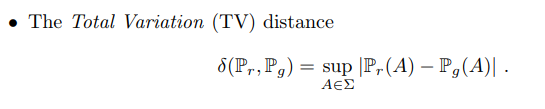

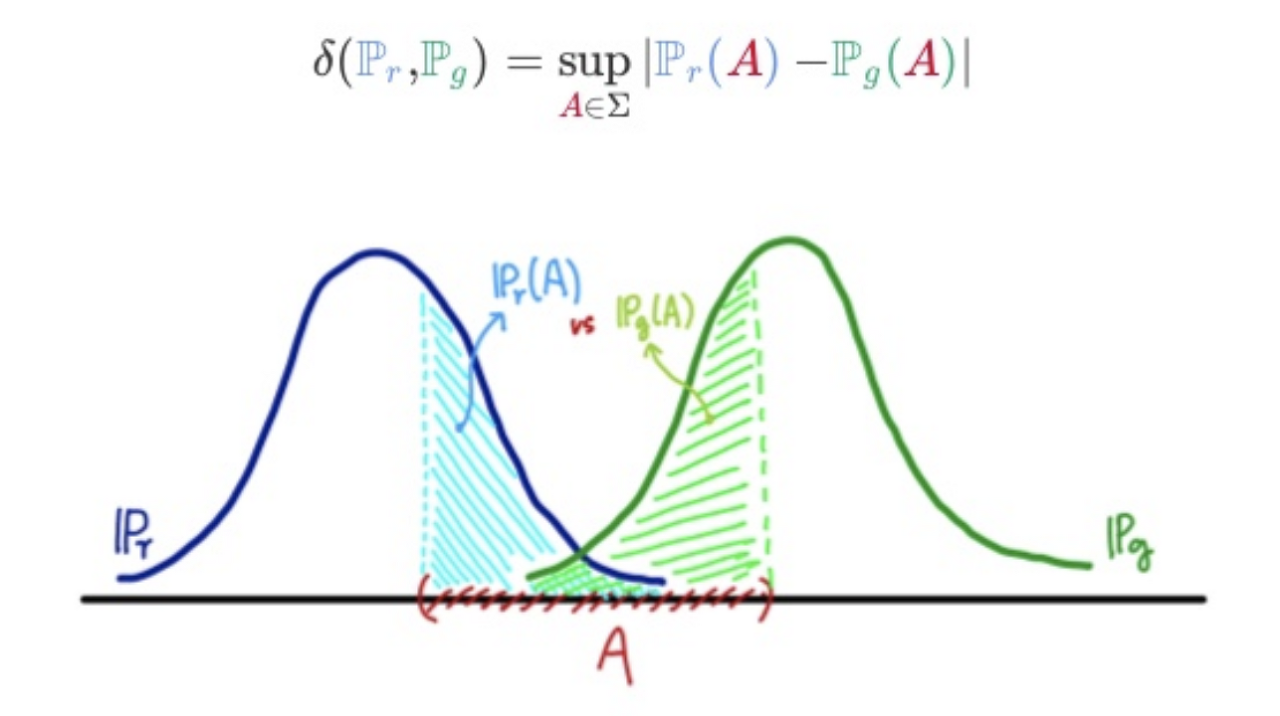

$$TV(X,Y)=Var(X)+Var(Y)-Cov(X,Y)$$

In [119]:
def calc_var(x, y, scaling=None, model_ctx=model_ctx):
    n = x.shape[0]
    sum_ = nd.zeros(1, ctx=model_ctx)
    ct = 0
    for i in range(n):
        for j in range(i+1, n):
            sum_ = sum_ + nd.norm(x[i] - y[j], ord=1)
            ct += 1
    if scaling is not None:
        ct = scaling
    sum_ = sum_ / ct
    return sum_

In [133]:
calc_var(x, x, 31*32) + calc_var(y, y, 31*32) - calc_var(x, y, 32*32)


[0.46886098]
<NDArray 1 @gpu(0)>

# Torch's Total Variation

In [143]:
import torch

In [174]:
def calc_var(x, v):
    n = x.size(0)
    sum_ = 0
    for i in range(n):
        for j in range(i+1, n):
            sum_ += torch.norm(x[i] - v[j], p=1).item()
    if torch.eq(x, v).all().item():
        scaling = n * (n - 1)
    else:
        scaling = n * n
    return sum_ / scaling

In [177]:
a = torch.FloatTensor(
    [[0, 0, 1],
     [0, 1, 0],
     [1, 0, 0],]
)

b = torch.FloatTensor(
    [[0, 0, 1],
     [0, 1, 0],
     [1, 0, 0]]
)

calc_var(a, a), calc_var(b, b), calc_var(a, b)

(1.0, 1.0, 1.0)

In [186]:
a = torch.FloatTensor(
    [[0.2, 0.3, 0.5],
     [0.1, 0.4, 0.5],
     [0.7, 0.1, 0.2],]
)

b = torch.FloatTensor(
    [[0.1, 0.3, 0.6],
     [0.3, 0.3, 0.4],
     [0.6, 0.2, 0.2]]
)


def tv(a, b):
    return calc_var(a, a) + calc_var(b, b) - calc_var(a, b)

tv(a, b)

0.5111111187272601

In [134]:
calc_var(x, x) + calc_var(y, y) - calc_var(x, y)


[0.88802195]
<NDArray 1 @gpu(0)>

In [128]:
"""
    [[ x_11 x_12 ... x_1K ]    [[ r_1 ]
     [ x_21 x_22 ... x_2K ]     [ r_2 ]
x =  [   :    :   :    :  ]  =  [  :  ]
     [ x_n1 x_n2 ... x_nK ]]    [ r_n ]] 일 때,
     
i \in (1, n)에 대하여 nC2 경우의 수만큼 L1 loss를 계산. 즉,
x_loss = {
    l1(r_1, r_2) + l1(r_1, r_3) + ... + l1(r_1, r_n-1) + l1(r_1, r_n)
                 + l1(r_2, r_3) + ... + l1(r_2, r_n-1) + l1(r_2, r_n)
                 ...
                                                       + l1(r_n-1, r_n)
}
x_loss /= n(n-1) (경우의 수만큼 나눠줌. 1/2는 남김.)
"""
sum_xx = nd.zeros(1, ctx=model_ctx)
for i in range(n): # for each i in batch_size
    for j in range(i+1, n):
        sum_xx = sum_xx + nd.norm(x[i] - x[j], ord=1)
sum_xx = sum_xx / (n * (n-1))
sum_xx


[0.87109524]
<NDArray 1 @gpu(0)>

In [129]:
"""
y = [[ y_11 y_12 ... y_1K ]  = [[ s_1 ]
     [ y_21 y_22 ... y_2K ]  =  [ s_2 ]
     [   :    :   :    :  ]  =  [ :  ]
     [ y_n1 y_n2 ... y_nK ]] =  [ s_n ]] 일 때,

i \in (1, n)에 대하여 nC2 경우의 수만큼 L1 loss를 계산. 즉,
y_loss = {
    l1(s1, s2) + l1(s1, s2) + ... + l1(s1, sn-1) + l1(s1, sn)
               + l1(s2, s3) + ... + l1(s2, sn-1) + l1(s2, sn)
               ...
                                                 + l1(sn-1, sn)
}
y_loss /= n(n-1)
"""
sum_yy = nd.zeros(1, ctx=model_ctx)
for i in range(y.shape[0]):
    for j in range(i+1, y.shape[0]):
        sum_yy = sum_yy + nd.norm(y[i] - y[j], ord=1)
sum_yy = sum_yy / (y.shape[0] * (y.shape[0]-1))
sum_yy


[0.368116]
<NDArray 1 @gpu(0)>

In [130]:
"""
x와 y의 차이로도 L1 norm을 계산. 총 n x n만큼의 값을 합산. 즉,
xy_loss = {
    l1(r_1, s_1) + l1(r_1, s_2) + ... + l1(r_1, s_n) +
    l1(r_2, s_1) + l1(r_2, s_2) + ... + l1(r_2, s_n) + ...
    l1(r_n, s_1) + l1(r_n, s_2) + ... + l1(r_n, s_n)
}
xy_loss /= n * n
"""
sum_xy = nd.zeros(1, ctx=model_ctx)
for i in range(n):
    for j in range(y.shape[0]):
        sum_xy = sum_xy + nd.norm(x[i] - y[j], ord=1)
sum_xy = sum_xy / (n * y.shape[0])
sum_xy


[1.6043831]
<NDArray 1 @gpu(0)>

In [124]:
sum_xx + sum_yy - sum_xy # TV


[-0.62733036]
<NDArray 1 @gpu(0)>

### (2) Diffusion
- 왜 모델 이름이 W-LDA인걸까...
- https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution
- https://stats.stackexchange.com/questions/400180/earth-movers-distance-and-maximum-mean-discrepency

### Geodesic distance
$$d(\theta,\theta^\prime)=2\arccos \bigg( \sum_{k=1}^{K} \sqrt{\theta_k \theta^\prime_k} \bigg)$$

### Information diffusion kernel
$$k(\theta,\theta^\prime)=\exp\bigg( -\arccos \bigg( \sum_{k=1}^{K} \sqrt{\theta_k \theta^\prime_k} \bigg) \bigg)$$

In [73]:
def diffusion_kernel(a, tmpt, dim):
    # return (4 * np.pi * tmpt) ** (-dim / 2) * nd.exp(-nd.square(nd.arccos(a)) / tmpt)
    return nd.exp(-nd.square(nd.arccos(a)) / tmpt)

In [74]:
# (bsz, # of topics)
qx = nd.sqrt(nd.clip(x, eps, 1))
qy = nd.sqrt(nd.clip(y, eps, 1))

# (bsz, bsz)
xx = nd.dot(qx, qx, transpose_b=True)
yy = nd.dot(qy, qy, transpose_b=True)
xy = nd.dot(qx, qy, transpose_b=True)

In [75]:
off_diag = 1 - nd.eye(n, ctx=model_ctx)
off_diag


[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
<NDArray 32x32 @gpu(0)>

In [76]:
k_xx = diffusion_kernel(nd.clip(xx, 0, 1-eps), t, d-1)
k_yy = diffusion_kernel(nd.clip(yy, 0, 1-eps), t, d-1)
k_xy = diffusion_kernel(nd.clip(xy, 0, 1-eps), t, d-1)

In [77]:
sum_xx = (k_xx * off_diag).sum() / (n * (n-1))
sum_yy = (k_yy * off_diag).sum() / (n * (n-1))
sum_xy = 2 * k_xy.sum() / (n * n)

In [78]:
sum_xx + sum_yy - sum_xy


[0.42240673]
<NDArray 1 @gpu(0)>

---

In [79]:
compute.args["l2_alpha"] > 0

False

In [80]:
loss_total.backward()

In [81]:
is_record.__exit__(None, None, None)
is_record._prev_is_record, is_record._prev_train_mode

None None None


(False, False)

In [82]:
compute.optimizer_enc.step(1)
compute.optimizer_dec.step(1)  # self.m.args['batch_size']

## Fourth, Calculate latent values

In [84]:
latent_max = nd.zeros(compute.args['ndim_y'], ctx=model_ctx)
for max_ind in nd.argmax(y_onehot_u, axis=1):
    latent_max[max_ind] += 1.0
latent_max


[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 23.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  7.  0.]
<NDArray 50 @gpu(0)>

In [85]:
latent_max /= batch_size
latent_max


[0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.71875 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.03125 0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.03125 0.      0.      0.21875 0.     ]
<NDArray 50 @gpu(0)>

In [86]:
latent_entropy = nd.mean(
    nd.sum(
        - y_onehot_u_softmax * nd.log(y_onehot_u_softmax + eps), 
        axis=1
    )
)
latent_entropy


[3.1898918]
<NDArray 1 @gpu(0)>

In [87]:
latent_v = nd.mean(y_onehot_u_softmax, axis=0)
latent_v


[0.01815579 0.01483574 0.01790153 0.00928641 0.00539703 0.00851394
 0.00396833 0.02619956 0.02938728 0.13920787 0.02276306 0.03055618
 0.01103391 0.00388262 0.017527   0.01664583 0.00944073 0.00911345
 0.04955071 0.01364621 0.01526994 0.01325219 0.00772867 0.02221724
 0.00481188 0.01572946 0.01106266 0.02710546 0.00475722 0.013262
 0.01099523 0.05098362 0.00637029 0.04459182 0.01712589 0.01226548
 0.0036876  0.0056433  0.00972925 0.02775203 0.00928195 0.01194198
 0.00933874 0.00920975 0.01342542 0.0462933  0.01579987 0.01610414
 0.08309863 0.00415182]
<NDArray 50 @gpu(0)>

In [88]:
dirich_entropy = nd.mean(nd.sum(- y_true * nd.log(y_true + eps), axis=1))
dirich_entropy


[2.190937]
<NDArray 1 @gpu(0)>

## Fifth, Calculate mmd loss return

In [91]:
if compute.args["adverse"]:
    loss_mmd_return = loss_mmd.asscalar()
loss_mmd_return

0.42240673

## Finally!

In [92]:
loss_reconstruction = nd.mean(loss_reconstruction).asscalar()
loss_discriminator = loss_mmd_return
latent_max = latent_max.asnumpy()
latent_entropy = latent_entropy.asscalar()
latent_v = latent_v.asnumpy()
dirich_entropy = dirich_entropy.asscalar()

In [96]:
sum_loss_discriminator += loss_discriminator
sum_loss_generator += loss_generator
sum_loss_autoencoder += loss_reconstruction
sum_discriminator_z_confidence_true += discriminator_z_confidence_true
sum_discriminator_z_confidence_fake += discriminator_z_confidence_fake
sum_discriminator_y_confidence_true += discriminator_y_confidence_true
sum_discriminator_y_confidence_fake += discriminator_y_confidence_fake

latent_max_distr += latent_max
latent_entropy_avg += latent_entropy
latent_v_avg += latent_v
dirich_avg_entropy += dirich_entropy

- 위를 계속 반복!